# Naive classifier

In [1]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_7596/2716140240.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


In [4]:
### this code it's exactly in  x weeks 
def prep_training_test_data(data, proportion, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15

            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week, inlcuding it as a feature

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -1)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)


In [ ]:
def calculate_ppv_npv(true_labels, predicted_labels):
    # Make sure the inputs have the same length
    if len(true_labels) != len(predicted_labels):
        raise ValueError("The true_labels and predicted_labels should have the same length.")

    true_positives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 1 and predicted_label == 1)
    false_positives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 0 and predicted_label == 1)
    true_negatives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 0 and predicted_label == 0)
    false_negatives = sum(1 for true_label, predicted_label in zip(true_labels, predicted_labels) if true_label == 1 and predicted_label == 0)

    ppv = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    npv = true_negatives / (true_negatives + false_negatives) if (true_negatives + false_negatives) > 0 else 0.0

    return ppv, npv

In [31]:
### this code it's ANY in the x week period 

def prep_training_test_data_period(data, proportion, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+1, test_week+1):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_15_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week, inlcuding it as a feature

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -1)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)

In [9]:
def calculate_ppv_npv(confusion_matrix):
    # Extract values from the confusion matrix
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    TN = confusion_matrix[0, 0]
    FN = confusion_matrix[1, 0]

    # Calculate PPV (Precision) and NPV
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0.0

    return ppv, npv



In [10]:

for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

In [11]:
## naive with only above/belwo 15 per 199k in current week 

data_by_HSA_over_15_100k = data_by_HSA[['HSA_ID', 'week', 'beds_over_15_100k']]
data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.pivot_table(index= 'week', columns='HSA_ID', values='beds_over_15_100k')

old_column_names = data_by_HSA_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.reset_index()


In [12]:
column_names = ['HSA_ID']
categories_for_subsetting = ['beds_over_15_100k']

for week in range(1, len(data_by_HSA_over_15_100k) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)

all_HSA_ID_weekly_data = pd.DataFrame(index=range(len(data_by_HSA['HSA_ID'].unique())), columns=column_names)

x = 0

categories_for_subsetting = ['beds_over_15_100k']
for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(data_by_HSA_over_15_100k) if HSA_col == HSA]
    all_HSA_ID_weekly_data.loc[x, 'HSA_ID'] = HSA
    columns_to_subset =  tuple([f'{HSA}_{category}' for category in categories_for_subsetting]) 
    #columns_to_subset =  [f'{HSA}_{category}' for category in categories_for_subsetting]
 
    j = 1
    try:
        for row in range(len(data_by_HSA_over_15_100k.loc[:, columns_to_subset])):
            all_HSA_ID_weekly_data.iloc[x, j:j + len(categories_for_subsetting)] = data_by_HSA_over_15_100k.loc[row,columns_to_subset]
            j += 1
    except:
        pass
    x += 1

for column in all_HSA_ID_weekly_data.columns[1:]:
    # Calculate the difference between each row and the previous row
    if "over" not in column.lower():
        diff = all_HSA_ID_weekly_data[column].diff()
        
        # Create a new column with the original column name and "delta"
        new_column_name = column + "_delta"
        
        column_index = all_HSA_ID_weekly_data.columns.get_loc(column)
        
        # Insert the new column just after the original column
        all_HSA_ID_weekly_data.insert(column_index + 1, new_column_name, diff)
        all_HSA_ID_weekly_data[new_column_name] = diff

In [13]:
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

# Period

In [32]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0]

Accuracy: 0.794728650696982
auROC: 0.794728650696982
[[ 6013  3516]
 [ 2551 17476]]


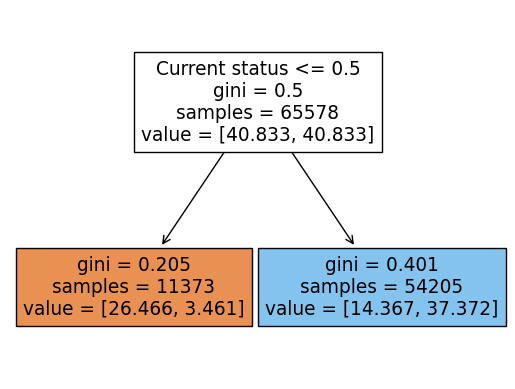

In [47]:


param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 100) #100, 200, 300, 400, 500], #np.arange(500, 200)
}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test[0], y_pred)
probabilities = clf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, probabilities)
print("Accuracy:", accuracy)
print("auROC:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['Current status'], filled=True)
plt.savefig('Graphs/Naive_classifier_3_week_period.png', dpi = 300)


In [45]:
best_params

{'min_samples_split': 9,
 'min_samples_leaf': 67,
 'max_depth': 9,
 'criterion': 'gini'}

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Calculate specificity (true negative rate)
specificity = TN / (TN + FP)
print(specificity)
# Calculate sensitivity (true positive rate)
sensitivity = TP / (TP + FN)
print(sensitivity)

ppv, npv = calculate_ppv_npv(conf_matrix)
print(ppv)
print(npv)


0.781585220500596
0.8453312574261482
0.9336591546746312
0.5815319809333777


In [40]:
weeks_to_predict = range(1,123)
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []

#
for prediction_week in weeks_to_predict: 
    
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
    weights = weights[0]
    clf.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    ROC_by_week.append(roc_auc_score(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week.append(TP / (TP + FN))

    ppv, npv = calculate_ppv_npv(conf_matrix)
    ppv_by_week.append(ppv)
    npv_by_week.append(npv)

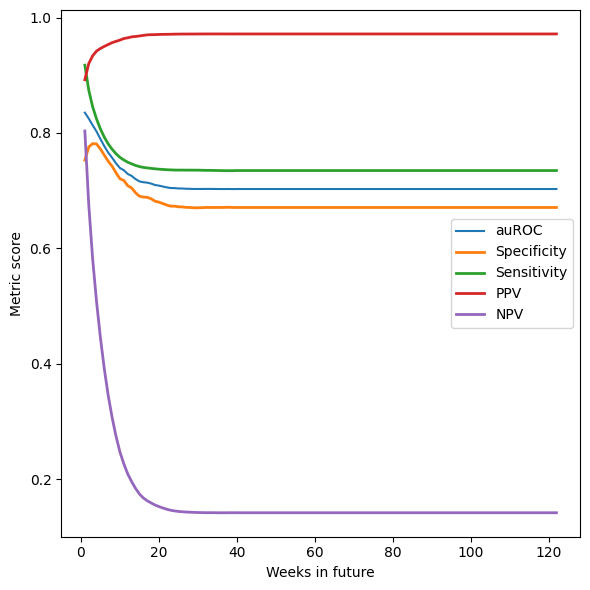

In [51]:
fig, axs = plt.subplots(figsize=(6, 6), facecolor='w', edgecolor='k', sharex='all', sharey='all')
axs.plot(weeks_to_predict, ROC_by_week, label = 'auROC')
axs.plot(weeks_to_predict, specificity_by_week, label = 'Specificity', linewidth=2)
axs.plot(weeks_to_predict, sensitivity_by_week, label = 'Sensitivity', linewidth=2)
axs.plot(weeks_to_predict, ppv_by_week, label = 'PPV', linewidth=2)
axs.plot(weeks_to_predict, npv_by_week, label = 'NPV', linewidth=2)
axs.legend()
axs.set_xlabel("Weeks in future")
axs.set_ylabel("Metric score")
plt.tight_layout()
#plt.savefig('Graphs/Naive_classifier_predict_each_week_period_model.png', dpi = 300)


# Exact date

In [42]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data, [3,2], no_weeks = range(int(123*2/3) + 1, 120), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight') #only goes to 120 as it's weeks in the future
weights = weights[0]

Accuracy: 0.794728650696982
auROC: 0.794728650696982
[[ 6013  3516]
 [ 2551 17476]]


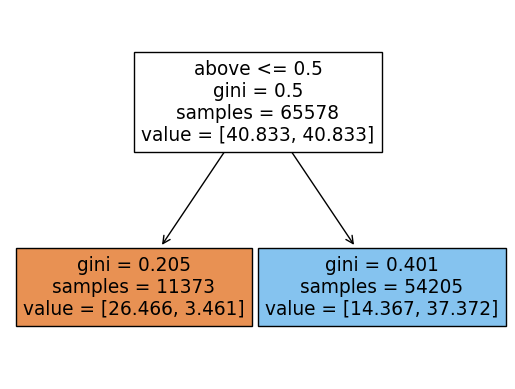

In [52]:
# Create a decision tree classifier
param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(50, 200),
    'min_samples_leaf': np.arange(50, 200)
}

param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 100) #100, 200, 300, 400, 500], #np.arange(500, 200)
}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test[0], y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['above'], filled=True)
plt.savefig('Graphs/Naive_classifier_3_week_exact.png', dpi = 300)


In [56]:
conf_matrix = confusion_matrix(y_test, y_pred)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Calculate specificity (true negative rate)
specificity = TN / (TN + FP)
print(specificity)
# Calculate sensitivity (true positive rate)
sensitivity = TP / (TP + FN)
print(sensitivity)

ppv, npv = calculate_ppv_npv(conf_matrix)
print(ppv)
print(npv)

0.6708529565672423
0.7348606599418704
0.9715641952983726
0.14187693669765383


In [54]:
weeks_to_predict = range(1,123)
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []

#
for prediction_week in weeks_to_predict: 
    
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID', weight_col = 'weight')

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data, [3,2], no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
    weights = weights[0]
    clf.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    ROC_by_week.append(roc_auc_score(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week.append(TP / (TP + FN))

    ppv, npv = calculate_ppv_npv(conf_matrix)
    ppv_by_week.append(ppv)
    npv_by_week.append(npv)

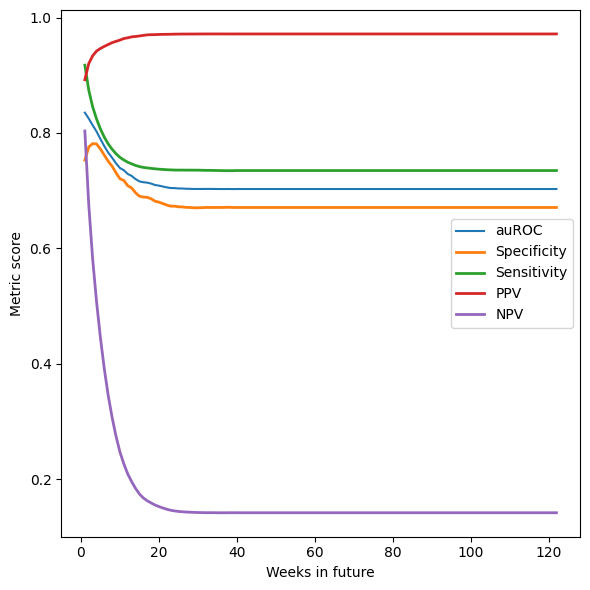

In [55]:
fig, axs = plt.subplots(figsize=(6, 6), facecolor='w', edgecolor='k', sharex='all', sharey='all')
axs.plot(weeks_to_predict, ROC_by_week, label = 'auROC')
axs.plot(weeks_to_predict, specificity_by_week, label = 'Specificity', linewidth=2)
axs.plot(weeks_to_predict, sensitivity_by_week, label = 'Sensitivity', linewidth=2)
axs.plot(weeks_to_predict, ppv_by_week, label = 'PPV', linewidth=2)
axs.plot(weeks_to_predict, npv_by_week, label = 'NPV', linewidth=2)
axs.legend()
axs.set_xlabel("Weeks in future")
axs.set_ylabel("Metric score")
plt.tight_layout()
plt.savefig('Graphs/Naive_classifier_predict_each_week_exact.png', dpi = 300)


In [ ]:
plt.savefig('Graphs/Naive_classifier_predict_each_week.png', dpi = 300)
